In [6]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Dataframes
command: disjoint speaker split

In [8]:
dataframe_dir = '/home/muncok/DL/dataset/SV_sets/dataframes/'
data_dir = '/home/muncok/DL/dataset/SV_sets/voxceleb/'
data_df = pd.read_pickle('/home/muncok/DL/dataset/SV_sets/dataframes/Voxc_Dataframe.pkl')

In [9]:
import honk_sv.train as hk
import honk_sv.model as mod
import honk_sv.dataset as dset
import honk_sv.system as svs

### Dataset split

In [10]:
#TODO: correct splits
all_spks = data_df.spk.unique()
uttrs_counts = data_df.spk.value_counts()
sv_spks = list(uttrs_counts.index[-40:])
si_spks = list(uttrs_counts.index[:-40])

In [7]:
# sentence duration
import librosa

audio_lengths = []
for idx, row in data_df.sample(n=10000).iterrows():
    file_path = os.path.join(data_dir, row.spk, row.file)
    x, sr = librosa.load(file_path, sr=16000)
    audio_lengths.append(len(x)/16000)

KeyboardInterrupt: 

In [ ]:
np.mean(audio_lengths_lengths)

# SI Train

In [11]:
import random 

si_df = data_df[data_df.spk.isin(si_spks)]

# random sampling
si_random_train = si_df.sample(frac=0.8)
si_random_test = si_df.drop(index=si_random_train.index)
si_random_val = si_random_test.sample(frac=0.5)
si_random_test = si_random_test.drop(index=si_random_val.index) 
print("[random] train:{}, val:{}, test:{}".format(len(si_random_train), len(si_random_val), len(si_random_test)))

[random] train:120605, val:15076, test:15075


In [13]:
import csv
import random

tags = ['train', 'val', 'test']
# choose a si split
sets = {'train':si_random_train, 'val':si_random_val, 'test':si_random_test}
manifest_dir = "manifests/voxc/"

for tag in tags:
    samples = []
    save_path = os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("voxc", tag))
    with open(save_path, 'w') as f:
        for index, row in sets[tag].iterrows():
            file_path = os.path.join(data_dir, row.spk, row.file)
            label = si_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

KeyboardInterrupt: 

In [14]:
model = "res8-wide"
dataset = "voxc"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0,
                     n_epochs=100, batch_size=64,
                     lr=[0.01, 0.001], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001,
                     num_workers=32, print_step=100,
                     splice_length = 20
                     )

builder = hk.ConfigBuilder(
                mod.find_config(model),
                dset.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
si_config = builder.config_from_argparse(parser)
si_config['model_class'] = mod.find_model(model)
hk.set_seed(si_config)

si_config['n_labels'] = len(si_spks)
manifest_dir = "manifests/voxc/"
for tag in ['train', 'val', 'test']:
    si_config['{}_manifest'.format(tag)]=os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("voxc", tag))

si_model = si_config['model_class'](si_config)
si_config['output_file'] = "models/voxc/si_voxc_uttrs_res8w_1.pt"
si_config['input_length'] = int(16000 * 4)  # 4 seconds
si_model.load("models/voxc/si_voxc_frames_res8w.pt")
print(si_model)

SpeechResModel (
  (conv0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool): AvgPool2d (size=[4, 3], stride=[4, 3], padding=0, ceil_mode=False, count_include_pad=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn6): Batc

In [12]:
hk.train(si_config, model=si_model)

train step #99 accuracy: 0.203125, loss: 6.0394110679626465
train step #199 accuracy: 0.171875, loss: 6.211956024169922
train step #299 accuracy: 0.109375, loss: 6.296002388000488
train step #399 accuracy: 0.296875, loss: 5.485069274902344
train step #499 accuracy: 0.1875, loss: 5.862046241760254
train step #599 accuracy: 0.234375, loss: 5.769883155822754
train step #699 accuracy: 0.203125, loss: 5.766931533813477
train step #799 accuracy: 0.109375, loss: 5.992050647735596
train step #899 accuracy: 0.171875, loss: 5.4476165771484375
train step #999 accuracy: 0.265625, loss: 5.210644721984863
train step #1099 accuracy: 0.203125, loss: 5.0600996017456055
train step #1199 accuracy: 0.125, loss: 5.751102924346924
train step #1299 accuracy: 0.15625, loss: 5.24673318862915
train step #1399 accuracy: 0.25, loss: 5.05450963973999
train step #1499 accuracy: 0.171875, loss: 5.510154724121094
train step #1599 accuracy: 0.21875, loss: 5.256772994995117
train step #1699 accuracy: 0.25, loss: 4.9570

train step #12999 accuracy: 0.515625, loss: 2.5197765827178955
train step #13099 accuracy: 0.453125, loss: 2.7993626594543457
epoch #6, final dev accuracy: 0.42986405367231634
saving best model...
train step #13199 accuracy: 0.4375, loss: 2.8496620655059814
train step #13299 accuracy: 0.296875, loss: 3.6991829872131348
train step #13399 accuracy: 0.484375, loss: 2.78743314743042
train step #13499 accuracy: 0.4375, loss: 2.778517246246338
train step #13599 accuracy: 0.5625, loss: 2.5158112049102783
train step #13699 accuracy: 0.34375, loss: 3.098752021789551
train step #13799 accuracy: 0.515625, loss: 2.652683973312378
train step #13899 accuracy: 0.578125, loss: 2.6815075874328613
train step #13999 accuracy: 0.375, loss: 3.0855026245117188
train step #14099 accuracy: 0.484375, loss: 2.8546125888824463
train step #14199 accuracy: 0.328125, loss: 3.3324294090270996
train step #14299 accuracy: 0.28125, loss: 3.1334705352783203
train step #14399 accuracy: 0.5625, loss: 2.5681464672088623
tr

Process Process-837:
Process Process-853:
Process Process-849:
Process Process-862:
Process Process-863:
Process Process-846:
Process Process-850:
Process Process-854:
Process Process-861:
Process Process-840:
Traceback (most recent call last):
Process Process-855:
Process Process-858:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-852:
Process Process-864:
Traceback (most recent call last):
Process Process-843:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-856:
Process Process-836:
Process Process-844:
Process Process-857:
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-834:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-860:
  File "/home/muncok/anacon

  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File 

  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._

KeyboardInterrupt
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt: 

#### SV Enrollment & Test

In [15]:
si_model.load("models/voxc/si_voxc_uttrs_res8w_1.pt")

In [16]:
import random
random.shuffle(sv_spks)
enroll_spks = sv_spks[:5]
test_spks = sv_spks[5:]

In [17]:
enroll_spks

['Nina_Arianda',
 'Jason_Dohring',
 'Joan_Cusack',
 'Walter_Matthau',
 'Max_Thieriot']

In [18]:
test_spks

['Beth_Grant',
 'Iain_Glen',
 'Kim_Zolciak-Biermann',
 'Ellen_Wong',
 'Raoul_Bova',
 'Shemar_Moore',
 'Sam_Palladio',
 'Blake_Michael',
 'Claudia_Lee',
 'Damon_Wayans',
 'Jennifer_Coolidge',
 'Steve_Harvey',
 'Steve_Burton',
 'Julianne_Nicholson',
 'Jacqueline_MacInnes_Wood',
 'Michael_Weatherly',
 'Dane_Cook',
 'Lacey_Turner',
 'Chris_Lowell',
 'Shiri_Appleby',
 'Olivia_Munn',
 'Shannen_Doherty',
 'Marisa_Miller',
 'Will_Mellor',
 'Donal_Logue',
 'Thomas_Jane',
 'Katie_Stevens',
 'Audrina_Patridge',
 'Alex_Pettyfer',
 'Leslie_Bibb',
 'Fanny_Ardant',
 'Steven_Soderbergh',
 'Violante_Placido',
 'Gary_Busey',
 'Ellen_Burstyn']

In [19]:
enroll_uttrs = pd.DataFrame()
dev_uttrs = pd.DataFrame()
enroll_pts = 0.3

sv_df = data_df[data_df.spk.isin(sv_spks)]
# splits enroll and dev
for spk in enroll_spks:
    spk_df = sv_df[sv_df.spk == spk]
    assert(len(spk_df) != 0)
    enls = spk_df.sample(frac=enroll_pts)
    devs = spk_df.drop(index=enls.index)
    enroll_uttrs = pd.concat([enls, enroll_uttrs])
    dev_uttrs = pd.concat([devs, dev_uttrs])
    
test_uttrs = sv_df[sv_df.spk.isin(test_spks)].sample(n=2*len(dev_uttrs))

In [20]:
enroll_uttrs.to_pickle("./enroll_uttrs.pkl")
dev_uttrs.to_pickle("./dev_uttrs.pkl")
test_uttrs.to_pickle("./test_uttrs.pkl")
# dev_uttrs = pd.read_pickle("./dev_uttrs.pkl")
# test_uttrs = pd.read_pickle("./test_uttrs.pkl")
# enroll_spks = list(dev_uttrs.spk.unique())

In [21]:
import csv
import random

manifest_dir = "./manifests/voxc/enroll/"
# delete existing files
for file in os.listdir(manifest_dir):
    file_path = os.path.join(manifest_dir, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        

for spk in enroll_spks:
    samples = []
    save_path = os.path.join(manifest_dir,'enroll_{}_{}_manifest.csv'.format("voxc", spk))
    with open(save_path, 'w') as f:
        for index, row in enroll_uttrs[enroll_uttrs.spk == spk].iterrows():
            file_path = os.path.join(data_dir, row.spk, row.file)
            label = enroll_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))    

./manifests/voxc/enroll/enroll_voxc_Nina_Arianda_manifest.csv was written
./manifests/voxc/enroll/enroll_voxc_Jason_Dohring_manifest.csv was written
./manifests/voxc/enroll/enroll_voxc_Joan_Cusack_manifest.csv was written
./manifests/voxc/enroll/enroll_voxc_Walter_Matthau_manifest.csv was written
./manifests/voxc/enroll/enroll_voxc_Max_Thieriot_manifest.csv was written


In [22]:
si_model = si_config['model_class'](si_config)
si_model.load("models/voxc/si_voxc_uttrs_res8w.pt")

In [23]:
# enrolling speakers
# generating speaker models
si_config['batch_size'] = 1
manifest_dir = "./manifests/voxc/enroll/"
spk_models = dict()
for spk in enroll_spks:
    manifest_path = os.path.join(manifest_dir, 'enroll_{}_{}_manifest.csv'.format("voxc", spk))
    si_config['test_manifest'] =  manifest_path
    spk_models[spk] = svs.enroll_uttr(si_config, model=si_model)
    

In [24]:
spk_model = [v for k,v in spk_models.items()]

In [25]:
from scipy.spatial.distance import cosine
import itertools

for spk1, spk2 in itertools.combinations(enroll_spks,2):
    score = 1-cosine(spk_models[spk1], spk_models[spk2])
    print("{}, {}: {:.2f}".format(spk1, spk2, score))

Nina_Arianda, Jason_Dohring: -0.53
Nina_Arianda, Joan_Cusack: 0.46
Nina_Arianda, Walter_Matthau: -0.36
Nina_Arianda, Max_Thieriot: -0.13
Jason_Dohring, Joan_Cusack: -0.58
Jason_Dohring, Walter_Matthau: 0.24
Jason_Dohring, Max_Thieriot: 0.50
Joan_Cusack, Walter_Matthau: -0.54
Joan_Cusack, Max_Thieriot: -0.35
Walter_Matthau, Max_Thieriot: -0.11


In [26]:
def pairwise_cosine(spk_model, test_in):
    nb_enroll_spks = len(spk_models.keys())
    scores = np.zeros(nb_enroll_spks)
    for i in range(nb_enroll_spks):
        signature = spk_model[i]
        scores[i] = 1-cosine(test_in, signature)
    return scores

In [27]:
corrects = 0
for idx, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.embed(si_config, si_model, audio_path)
    pred_spk = np.argmax(pairwise_cosine(spk_model, emb))
    label = enroll_spks.index(row.spk)
    if pred_spk == label:
        corrects += 1

print("SI Acc: {}".format(corrects/ len(dev_uttrs)))

SI Acc: 0.937888198757764


In [28]:
nb_total_uttrs = len(dev_uttrs)+len(test_uttrs)
n_classes = len(enroll_spks)
score_vector = np.zeros((nb_total_uttrs, n_classes))
label_vector = np.zeros((nb_total_uttrs, n_classes))

spk_model = [v for k,v in spk_models.items()]
spk_labels = list(spk_models.keys())

i = 0
for idx, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.embed(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_model, emb)
    label = spk_labels.index(row.spk)
    label_vector[i, label] = 1
    i+=1

In [29]:
for idx, row in test_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.embed(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_model, emb)
    i+=1

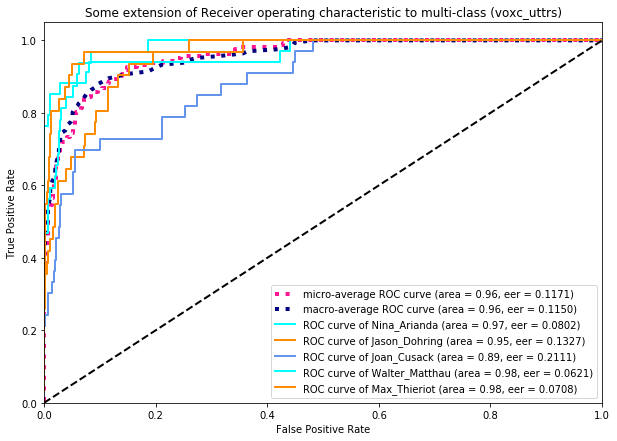

In [30]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
eer = dict()
thres = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thres[i] = roc_curve(label_vector[:, i], score_vector[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thres["micro"] = roc_curve(label_vector.ravel(), score_vector.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
eer["micro"] = fpr["micro"][np.nanargmin(np.abs(fpr["micro"] - (1 - tpr["micro"])))]

for i in range(n_classes):
    eer[i] = fpr[i][np.nanargmin(np.abs(fpr[i] - (1 - tpr[i])))]

from scipy import interp
from itertools import cycle
lw = 2
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
eer["macro"] = fpr["macro"][np.nanargmin(np.abs(fpr["macro"] - (1 - tpr["macro"])))]
# Plot all ROC curves
fig = plt.figure(figsize=(10,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["micro"], eer["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["macro"], eer["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f}, eer = {2:0.4f})'
             ''.format(spk_labels[i], roc_auc[i], eer[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class (voxc_uttrs)')
plt.legend(loc="lower right")
plt.show()